## Setup


In [16]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
import os
import random
import numpy as np
import tensorflow as tf

from PIL import Image
from skimage.color import rgb2gray

%matplotlib inline
import matplotlib.pyplot as plt
from openslide import open_slide, __library_version__ as openslide_version

In [0]:
# functions provided by Joshua Gordon
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

## Download Data
Skip this section if you already have data in the Google Drive

In [0]:
#read data from google bucket
slides_num = ['002', '012', '016', '019', '023', '031', '035', '057', '059', '064', '075', '078', '081', '084', '091', '094', '101']
data_url = 'https://storage.googleapis.com/applied-deep-learning/Final_Project/'
slides_path = [('tumor_' + num + '.tif') for num in slides_num]
tumor_masks_path = [('tumor_' + num + '_mask.tif') for num in slides_num]

slides = []
tumor_masks = []

for sp in slides_path:
  if not os.path.exists(sp):
    slide_url = data_url+sp
    !curl -O $slide_url
  slides.append(open_slide(sp))
  
for tmp in tumor_masks_path:
  if not os.path.exists(tmp):
    mask_url = data_url+tmp
    !curl -O $mask_url
  tumor_masks.append(open_slide(tmp))

In [26]:
!ls

gdrive		    tumor_019.tif	tumor_059_mask.tif  tumor_081.tif
sample_data	    tumor_023_mask.tif	tumor_059.tif	    tumor_084_mask.tif
tumor_002_mask.tif  tumor_023.tif	tumor_064_mask.tif  tumor_084.tif
tumor_002.tif	    tumor_031_mask.tif	tumor_064.tif	    tumor_091_mask.tif
tumor_012_mask.tif  tumor_031.tif	tumor_075_mask.tif  tumor_091.tif
tumor_012.tif	    tumor_035_mask.tif	tumor_075.tif	    tumor_094_mask.tif
tumor_016_mask.tif  tumor_035.tif	tumor_078_mask.tif  tumor_094.tif
tumor_016.tif	    tumor_057_mask.tif	tumor_078.tif	    tumor_101_mask.tif
tumor_019_mask.tif  tumor_057.tif	tumor_081_mask.tif  tumor_101.tif


In [0]:
# Verify downsampling works as expected
for slide in slides:
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

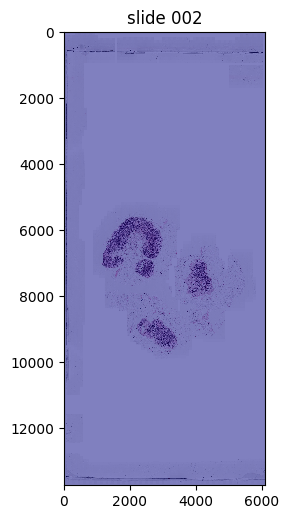

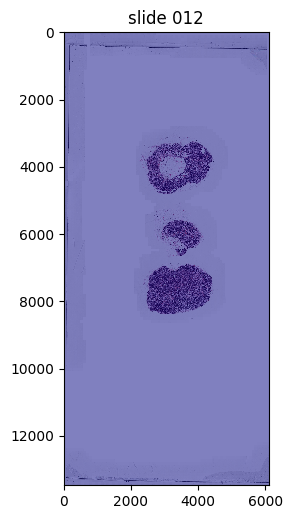

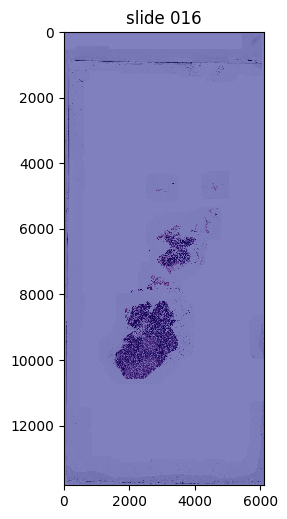

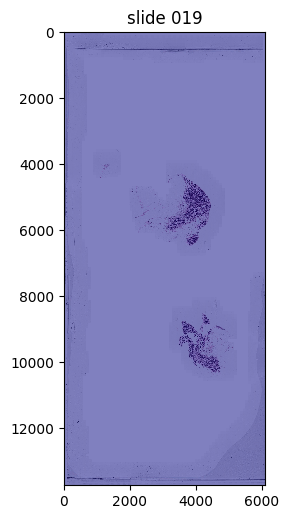

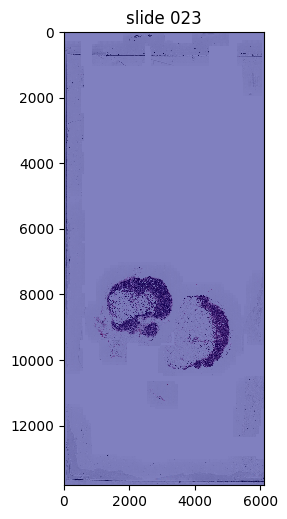

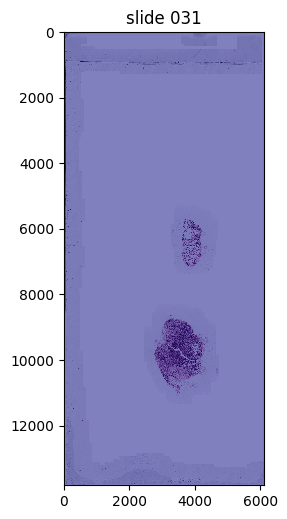

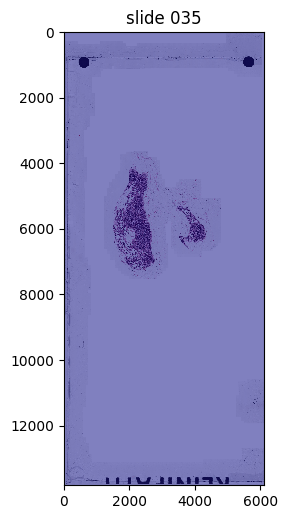

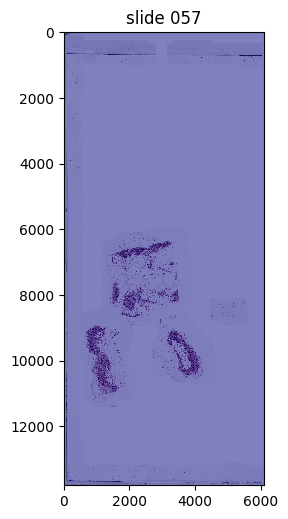

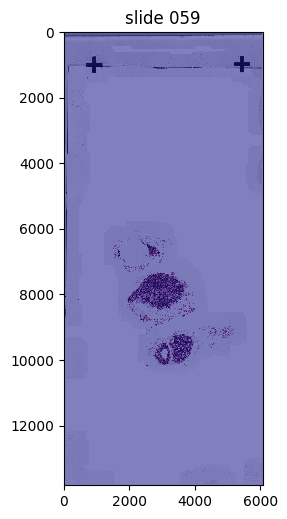

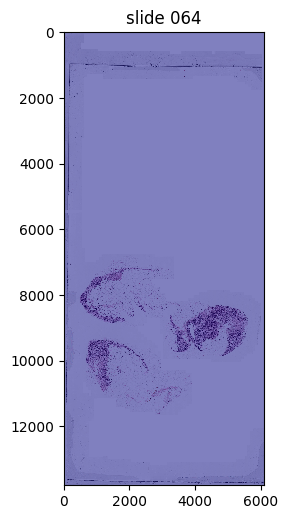

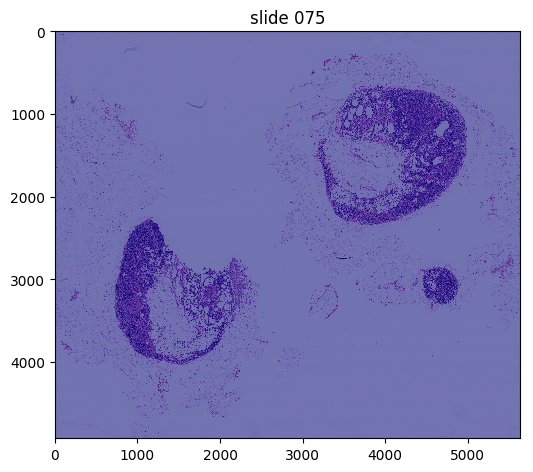

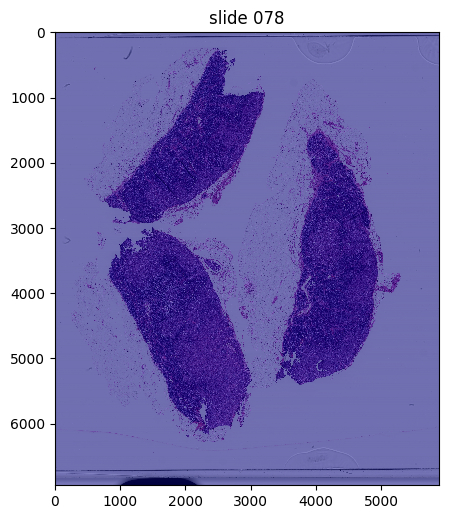

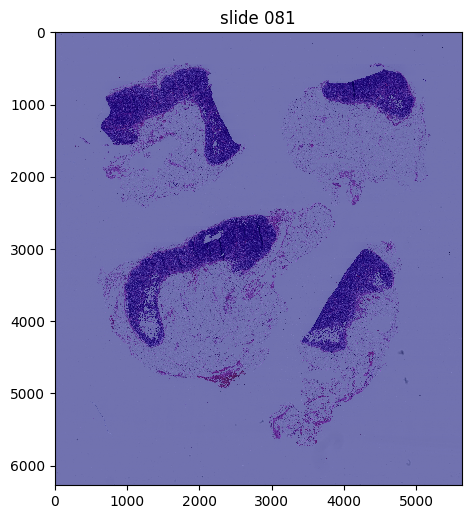

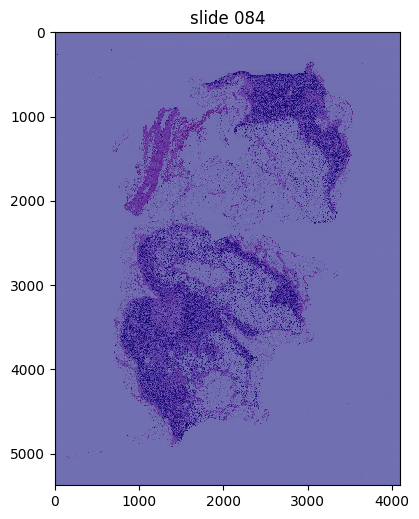

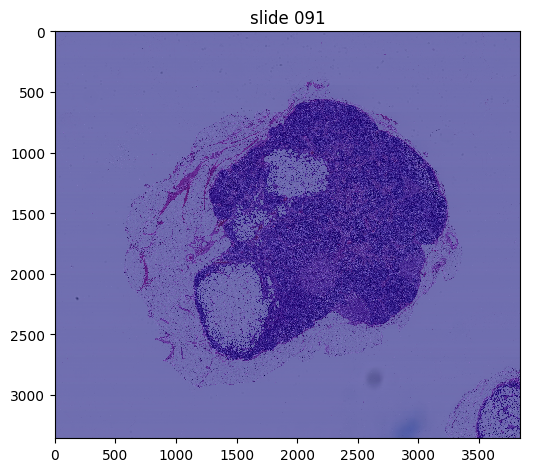

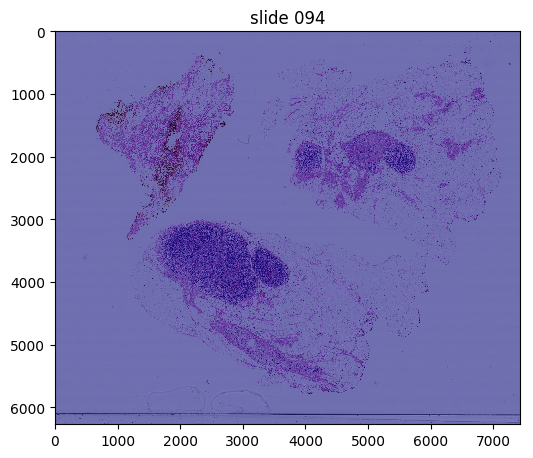

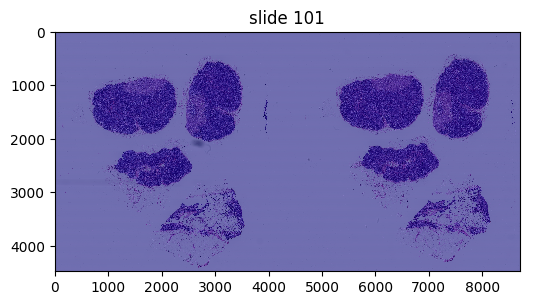

In [7]:
# Take a look at all slides at level 5
for slide, tumor_mask, slide_num in zip(slides, tumor_masks, slides_num):
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=7, 
                           width=slide.level_dimensions[4][0], 
                           height=slide.level_dimensions[4][1])
  mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=7, 
                          width=slide.level_dimensions[4][0], 
                          height=slide.level_dimensions[4][1])
  mask_image = mask_image[:,:,0]

  plt.figure(figsize=(6, 6), dpi=100)
  plt.title("slide {}".format(slide_num))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

## Generating Dataset
Skip this section if you already have data in the Google Drive

In [0]:
def is_tumor_at_center(mask, center_size):
  patch_size = mask.shape[0]
  offset = (patch_size - center_size) // 2
  n_tumor_pixels = np.sum(mask[offset:offset + center_size, offset:offset + center_size])
  return n_tumor_pixels > 0

def get_patch(slide, tumor_mask, x, y, level, patch_size):
  # get patch centered at (x, y)
  
  x, y = int(x), int(y)
  half_patch_len = int(patch_size // 2 * slide.level_downsamples[level])
  
  slide_image = read_slide(slide, 
                           x - half_patch_len, 
                           y - half_patch_len, 
                           level, 
                           width=patch_size, 
                           height=patch_size)
  mask_image = read_slide(tumor_mask, 
                          x - half_patch_len, 
                          y - half_patch_len, 
                          level, 
                          width=patch_size, 
                          height=patch_size)
  mask_image = mask_image[:, :, 0]
  return slide_image, mask_image

def get_pixels(slide, tumor_mask, checking_level, half_patch_len):
    assert slide.level_dimensions[checking_level] == tumor_mask.level_dimensions[checking_level]
    slide_image = read_slide(slide,
                             x=0,
                             y=0,
                             level=checking_level,
                             width=slide.level_dimensions[checking_level][0],
                             height=slide.level_dimensions[checking_level][1])
    mask_image = read_slide(tumor_mask,
                            x=0,
                            y=0,
                            level=checking_level,
                            width=tumor_mask.level_dimensions[checking_level][0],
                            height=tumor_mask.level_dimensions[checking_level][1])
    mask_image = mask_image[:,:,0]
    
    slide_image_cropped = slide_image[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
    mask_image_cropped  = mask_image[half_patch_len:-half_patch_len, half_patch_len:-half_patch_len]
    
    tissue_pixels = find_tissue_pixels(slide_image_cropped)
    tissue_mask = apply_mask(slide_image_cropped, tissue_pixels)
    
    # list of (x, y)
    normal_pixels = list(zip(*np.nonzero(tissue_mask[:, :, 0] - 255 * mask_image_cropped)))
    tumor_pixels = list(zip(*np.nonzero(mask_image_cropped)))
    
    return normal_pixels, tumor_pixels

def generate_dataset(slides, tumor_masks,
                     level1, level2,
                     checking_level,
                     n_data=2500,
                     patch_size=299,
                     center_size=128):
  """
  inputs:
    slides:
      list of openslide files, of tissues
    tumor_masks:
      list of openslide files, of tumor masks
    level1, level2:
      int, zoom levels
    n_data:
      int, number of data points
    patch_size:
      int, size of the square patch extracted from slides
    center_size:
      int, size of the square center in the patch
  outputs:
    X1:
      np.array of patches at zoom level1
    X2:
      np.array of patches at zoom level2
    y:
      np.array of labels
  """
  assert n_data % 2 == 0
  
  # check which slides have tumors using tumor mask at a certain level
  checking_level = checking_level
  half_patch_len = patch_size // 2
  
  slide_has_normal_pixels = np.zeros(len(slides)).astype(bool)
  slide_has_tumor_pixels = np.zeros(len(tumor_masks)).astype(bool)
  
  for i, (slide, tumor_mask) in enumerate(zip(slides, tumor_masks)):
    normal_pixels, tumor_pixels = get_pixels(slide, tumor_mask, checking_level, half_patch_len)
    slide_has_normal_pixels[i] = normal_pixels is not None
    slide_has_tumor_pixels[i] = tumor_pixels is not None
  
  X1 = []
  X2 = []
  X1_mask = []
  X2_mask = []
  Y = []
  
  slide_has_normal_pixels = slide_has_normal_pixels.astype(float)
  slide_has_tumor_pixels = slide_has_tumor_pixels.astype(float)
  slide_normal_p = slide_has_normal_pixels / np.sum(slide_has_normal_pixels)
  slide_tumor_p = slide_has_tumor_pixels / np.sum(slide_has_tumor_pixels)
  
  
  n_normal_data_on_each_slide = np.random.multinomial(n_data / 2, slide_normal_p)
  n_tumor_data_on_each_slide = np.random.multinomial(n_data / 2, slide_tumor_p)

  for i, (slide, tumor_mask, n_normal_data, n_tumor_data) in \
    enumerate(zip(slides, tumor_masks, n_normal_data_on_each_slide, n_tumor_data_on_each_slide)):

    print("process slide {:>4d} / {}".format(i + 1, len(slides)))

    normal_pixels, tumor_pixels = get_pixels(slide, tumor_mask, checking_level, half_patch_len)
    normal_pixels = [(x + half_patch_len, y + half_patch_len) for y, x in normal_pixels]
    tumor_pixels = [(x + half_patch_len, y + half_patch_len) for y, x in tumor_pixels]
 
    for i in range(n_normal_data + n_tumor_data):

      choose_tumor = i < n_normal_data
      chosen_pixels = tumor_pixels if choose_tumor else normal_pixels

      # randomly choose one patch from the chosen slide
      found_patch = False
      while not found_patch:
        x, y = random.choice(chosen_pixels)
        x = x * slide.level_downsamples[checking_level]
        y = y * slide.level_downsamples[checking_level]

        patch_image1, patch_mask1 = get_patch(slide, tumor_mask, x, y, level1, patch_size)

        exist_tumor = is_tumor_at_center(patch_mask1, center_size)

        tissue_pixels = find_tissue_pixels(patch_image1)
        tissue_percentage = float(len(list(tissue_pixels))) / patch_size**2 * 100

        if tissue_percentage > 50 and exist_tumor == choose_tumor:
          found_patch = True

          patch_image2, patch_mask2 = get_patch(slide, tumor_mask, x, y, level2, patch_size)
          X1.append(patch_image1)
          X2.append(patch_image2)
          X1_mask.append(patch_mask1)
          X2_mask.append(patch_mask2)
          Y.append(int(choose_tumor))
        
  X1, X2, X1_mask, X2_mask, Y = np.array(X1), np.array(X2), np.array(X1_mask), np.array(X2_mask), np.array(Y)
  return X1, X2, X1_mask, X2_mask, Y

In [9]:
LEVEL1 = 0
LEVEL2 = 1
CHECKING_LEVEL = 5

n_train = 800
n_test = 200

training_slides_num = ['016', '019', '031', '064', '075', '078', '084', '094', '101']
testing_slides_num = ['091']
training_slides = [slides[slides_num.index(num)] for num in training_slides_num]
testing_slides = [slides[slides_num.index(num)] for num in testing_slides_num]
training_masks = [tumor_masks[slides_num.index(num)] for num in training_slides_num]
testing_masks = [tumor_masks[slides_num.index(num)] for num in testing_slides_num]

print("Generating Training Data")
X1_train, X2_train, X1_mask_train, X2_mask_train, y_train = \
  generate_dataset(training_slides, training_masks, LEVEL1, LEVEL2, CHECKING_LEVEL, n_data=900)
print("Generating Testing Data")
X1_test, X2_test, X1_mask_test, X2_mask_test, y_test = \
  generate_dataset(testing_slides, testing_masks, LEVEL1, LEVEL2, CHECKING_LEVEL, n_data=100)

Generating Training Data
process slide    1 / 9
process slide    2 / 9
process slide    3 / 9
process slide    4 / 9
process slide    5 / 9
process slide    6 / 9
process slide    7 / 9
process slide    8 / 9
process slide    9 / 9
Generating Testing Data
process slide    1 / 1


In [10]:
print("Training Data")
print(X1_train.shape, X2_train.shape, X1_mask_train.shape, X2_mask_train.shape, y_train.shape)
print("Testing Data")
print(X1_test.shape, X2_test.shape, X1_mask_test.shape, X2_mask_test.shape, y_test.shape)

Training Data
(900, 299, 299, 3) (900, 299, 299, 3) (900, 299, 299) (900, 299, 299) (900,)
Testing Data
(100, 299, 299, 3) (100, 299, 299, 3) (100, 299, 299) (100, 299, 299) (100,)


1


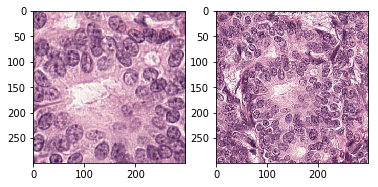

In [11]:
i = 3
x1, x2, label = X1_train[i], X2_train[i], y_train[i]
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)
print(label)

## Save Data to Google Drive
Skip this section if you already have data in the Google Drive

In [12]:
#get access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def upload_images(X1, X2, X1_mask, X2_mask, y, level1, level2, is_train=True):
  """
  upload images to google drive
  """

  drive_dir = '/content/gdrive/My Drive'
  main_dir = os.path.join(drive_dir, 'ADL_Project_v2')
  sub_dir = os.path.join(main_dir, 'train' if is_train else 'test')
  print(sub_dir)
  if not os.path.exists(drive_dir):
    raise ValueError('not connected to Google drive')
  if not os.path.exists(main_dir):
    os.mkdir(main_dir)
  if not os.path.exists(sub_dir):
    os.mkdir(sub_dir)
    
  np.save(os.path.join(sub_dir, 'X1'), X1)
  np.save(os.path.join(sub_dir, 'X2'), X2)
  np.save(os.path.join(sub_dir, 'X1_mask'), X1_mask)
  np.save(os.path.join(sub_dir, 'X2_mask'), X2_mask)
  np.save(os.path.join(sub_dir, 'y'), y)

  local_path_X1 = os.path.join(sub_dir, 'level{}'.format(level1))
  local_path_X2 = os.path.join(sub_dir, 'level{}'.format(level2))
  
  if not os.path.exists(local_path_X1):
    os.mkdir(local_path_X1)
  if not os.path.exists(local_path_X2):
    os.mkdir(local_path_X2)
  
  normal_idx = 0
  tumor_idx = 0
  for X1i, X2i, yi in zip(X1, X2, y):
    im_X1 = Image.fromarray(X1i)
    im_X2 = Image.fromarray(X2i)

    if yi == 0:
      idx = normal_idx
      normal_idx += 1
      local_path_X1i = os.path.join(local_path_X1, 'normal')
      local_path_X2i = os.path.join(local_path_X2, 'normal')
    else:
      idx = tumor_idx
      tumor_idx += 1
      local_path_X1i = os.path.join(local_path_X1, 'tumor')
      local_path_X2i = os.path.join(local_path_X2, 'tumor')
      
    if not os.path.exists(local_path_X1i):
      os.mkdir(local_path_X1i)
    if not os.path.exists(local_path_X2i):
      os.mkdir(local_path_X2i)

    local_file_name_X1 = '{:04d}.jpg'.format(idx)
    local_file_name_X2 = '{:04d}.jpg'.format(idx)

    local_file_path_X1 = os.path.join(local_path_X1i, local_file_name_X1)
    local_file_path_X2 = os.path.join(local_path_X2i, local_file_name_X2)

    im_X1.save(local_file_path_X1)
    im_X2.save(local_file_path_X2)

In [17]:
upload_images(X1_train, X2_train, X1_mask_train, X2_mask_train, y_train, LEVEL1, LEVEL2, is_train=True)
upload_images(X1_test, X2_test, X1_mask_test, X2_mask_test, y_test, LEVEL1, LEVEL2, is_train=False)

/content/gdrive/My Drive/ADL_Project_v2/train
/content/gdrive/My Drive/ADL_Project_v2/test


## Load Data from Google Drive

In [1]:
#get access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_dir = '/content/gdrive/My Drive/ADL_Project_v2/train'
test_dir = '/content/gdrive/My Drive/ADL_Project_v2/test'
assert os.path.exists(train_dir)
assert os.path.exists(test_dir)

X1_train, X2_train, y_train = np.load(train_dir + '/X1.npy'), np.load(train_dir + '/X2.npy'), np.load(train_dir + '/y.npy')
X1_test, X2_test, y_test = np.load(test_dir + '/X1.npy'), np.load(test_dir + '/X2.npy'), np.load(test_dir + '/y.npy')
X1_train, X2_train = X1_train.astype('float32'), X2_train.astype('float32')
X1_test, X2_test = X1_test.astype('float32'), X2_test.astype('float32')

## Prepare Data Generators
To enable that the ImageDataGenerator will apply the same preprocessing to both input images, rewrite a customized ImageDataGenerator.

In [7]:
from keras.preprocessing.image import NumpyArrayIterator, ImageDataGenerator

class CustomizedNumpyArrayIterator(NumpyArrayIterator):
  def _get_batches_of_transformed_samples(self, index_array):
    batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]), dtype=self.dtype)
    batch_x_miscs = []
    if not self.x_misc:
      batch_x_miscs = [np.zeros(tuple([len(index_array)] + list(xx.shape)[1:]), dtype=self.dtype) for xx in self.x_misc]
    for i, j in enumerate(index_array):
      x = self.x[j]
      params = self.image_data_generator.get_random_transform(x.shape)
      x = self.image_data_generator.apply_transform(x.astype(self.dtype), params)
      x = self.image_data_generator.standardize(x)
      batch_x[i] = x
      for k, xx in enumerate(self.x_misc):
        x = xx[j]
        x = self.image_data_generator.apply_transform(x.astype(self.dtype), params)
        x = self.image_data_generator.standardize(x)
        batch_x_miscs[k][i] = x

    output = (batch_x if batch_x_miscs == [] else [batch_x] + batch_x_miscs,)
    if self.y is None:
      return output[0]

    output += (self.y[index_array],)

    return output
  
class CustomizedImageDataGenerator(ImageDataGenerator):
  def flow(self,
           x,
           y=None,
           batch_size=32,
           shuffle=True,
           sample_weight=None,
           seed=None,
           save_to_dir=None,
           save_prefix='',
           save_format='png',
           subset=None):
    return NumpyArrayIterator(
      x,
      y,
      self,
      batch_size=batch_size,
      shuffle=shuffle,
      sample_weight=sample_weight,
      seed=seed,
      data_format=self.data_format,
      save_to_dir=save_to_dir,
      save_prefix=save_prefix,
      save_format=save_format,
      subset=subset
    )

def get_generator(X1, X2, y, is_train=True):
  """
  input: slides_dir: directory of slides
         masks_dir: directory of masks
         default upload from google drive
  """
  if is_train:
    data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=90,
                         width_shift_range=(-8, 8),
                         height_shift_range=(-8, 8)
                        # brightness_range=(0, 64./255),
                         
                        )
  else:
    data_gen_args = dict(rescale=1./255)

  data_gen = CustomizedImageDataGenerator(**data_gen_args)

  seed = 0

  data_generator = data_gen.flow((X1, X2), y, shuffle=True, seed=seed)

  return data_generator

Using TensorFlow backend.


In [0]:
train_generator = get_generator(X1_train, X2_train, y_train, is_train=True)
test_generator = get_generator(X1_test, X2_test, y_test, is_train=False)

## Model and Training

In [0]:
from keras.models import Model
from keras.layers import Flatten, Input, Dense, Dropout
from keras.layers import concatenate
from keras.applications.inception_v3 import InceptionV3

PATCH_SIZE = 299

def multi_scale_model():
  conv_base_1 = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
  conv_base_2 = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
  conv_base_1.trainable = False
  conv_base_2.trainable = False

  # to avoid name conflict
  conv_base_1.name = conv_base_1.name + "_base_1"
  conv_base_1.name = conv_base_2.name + "_base_2"
  
  for layer1, layer2 in zip(conv_base_1.layers, conv_base_2.layers):
    layer1.name = layer1.name + "_base_1"
    layer2.name = layer2.name + "_base_2"
    
  in1, feature1 = conv_base_1.input, conv_base_1.output
  in2, feature2 = conv_base_2.input, conv_base_2.output
  
  flat1 = Flatten()(feature1)
  flat2 = Flatten()(feature2)
  flat = concatenate([flat1, flat2])

  dense = Dense(256, activation='relu')(flat)
  dense = Dropout(.5)(dense)
  out = Dense(1, activation='sigmoid')(dense)

  model = Model([in1, in2], out)
  return model

In [12]:
from keras.optimizers import Adam

BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-4
monitor = 'val_loss'

model = multi_scale_model()
model.compile(Adam(lr=LR),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# prepare dir to save weights
import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

date = str(datetime.datetime.now())
date = 'D' + date[2:4] + date[5:7] + date[8:10] + '_' + date[11:13] + date[14:16] + date[17:19]

weight_dir = '/content/gdrive/My Drive/ADL_Project_v2/weights'
log_dir = os.path.join(weight_dir, date)
weight_file = os.path.join(log_dir, 'weights.h5')
if not os.path.exists(weight_dir):
  os.mkdir(weight_dir)
if not os.path.exists(log_dir):
  os.mkdir(log_dir)

# call back functions
model_checkpoint = ModelCheckpoint(weight_file, verbose=1, mode='auto',
                                   monitor=monitor, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=15, mode='auto',
                              factor=0.7, cooldown=0, min_lr=1e-5, verbose=2)
callback_list = [model_checkpoint, reduce_lr]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
import math
history = model.fit_generator(train_generator,
                              steps_per_epoch=math.ceil(X1_train.shape[0] / BATCH_SIZE),
                              epochs=EPOCHS,
                              verbose=2,
                              callbacks=callback_list,
                              validation_data=test_generator,
                              validation_steps=math.ceil(X1_test.shape[0] / BATCH_SIZE))

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 70s - loss: 6.5621 - acc: 0.5310 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 8.05905, saving model to /content/gdrive/My Drive/ADL_Project_v2/weights/D190512_000954/weights.h5
Epoch 2/30
 - 30s - loss: 1.3991 - acc: 0.8104 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 8.05905
Epoch 3/30
 - 31s - loss: 0.6315 - acc: 0.8954 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_loss improved from 8.05905 to 8.05905, saving model to /content/gdrive/My Drive/ADL_Project_v2/weights/D190512_000954/weights.h5
Epoch 4/30
 - 31s - loss: 0.2811 - acc: 0.9388 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00004: val_loss improved from 8.05905 to 8.05905, saving model to /content/gdrive/My Drive/ADL_Project_v2/weights/D190512_000954/weights.h5
Epoch 5/30
 - 31s - loss: 0.2713 - acc: 0.9487 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00005: val_loss improved from 8.0590

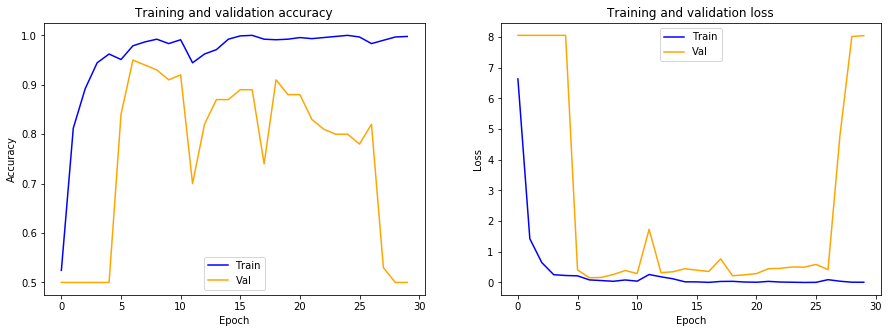

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [0]:
vis = next(train_generator)


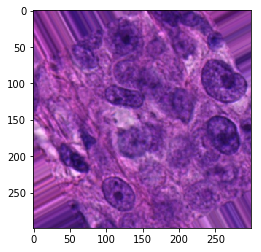

In [10]:
#plt.imshow(vis[0][0][0])
plt.imshow(vis[0][0][0].astype(int))

## Evaluations

In [0]:
# load model with saved weights
model = multi_scale_model()

log_dir_name = 'D190512_000954'
weight_dir = '/content/gdrive/My Drive/ADL_Project_v2/weights'
log_dir = os.path.join(weight_dir, log_dir_name)
weight_file = os.path.join(log_dir, 'weights.h5')
model.load_weights(weight_file)

In [0]:
def predict(level1_imgs, level2_imgs):
  """
  inputs:
    level1_imgs: shape = (n_data, PATCH_SIZE, PATCH_SIZE, 3)
    level2_imgs: shape = (n_data, PATCH_SIZE, PATCH_SIZE, 3)
  output:
    y_pred: shape = (n_data,)
  """
  n_data, patch_size, _, _ = level1_imgs.shape
  y = -np.ones(n_data)
  
  level1_imgs_pred = []
  level2_imgs_pred = []
  for i, (level1_img, level2_img) in enumerate(zip(level1_imgs, level2_imgs)):
    tissue_pixels = find_tissue_pixels(level1_img)
    tissue_percentage = float(len(list(tissue_pixels))) / patch_size**2 * 100

    # filter out patches with tissue percentage <= 50% and assume them to be normal
    if tissue_percentage > 50:
      level1_imgs_pred.append(level1_img)
      level2_imgs_pred.append(level2_img)
    else:
      y[i] = 0
  print(type(level1_imgs_pred))    
  y_pred = model.predict([level1_imgs_pred, level2_imgs_pred])
  y_pred_idx = 0
  for i in range(n_data):
    if y[i] == -1:
      y[i] = y_pred[y_pred_idx]
      y_pred_idx += 1

  return y

In [0]:
def get_heatmap(slide_num, level1, level2, patch_size=299, center_size=128):
  #read slide 
  slide = slides[slide_num]
  tumor_mask = tumor_masks[slide_num]
  
  slide_l7 = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=7, 
                           width=slide.level_dimensions[7][0], 
                           height=slide.level_dimensions[7][1])
  
  #get patches from level1 and level2
  
  X, Y = patch_size // 2, patch_size // 2
  W1 = slide.level_dimensions[level1][0]
  H1 = slide.level_dimensions[level1][1]
  W2 = slide.level_dimensions[level2][0]
  H2 = slide.level_dimensions[level2][1]
  W7, H7 =slide.level_dimensions[7][0], slide.level_dimensions[7][1]
  prediction = []
  true_label = []
  for j in range(H1 // H7):
    patches_l1, patches_l2 = [], []
    
    for i in range(W1//W7):


      patch_image1, patch_mask1 = get_patch(slide, tumor_mask, X, Y, level1, patch_size)
      patch_image2, _ = get_patch(slide, tumor_mask, X, Y, level2, patch_size)    

      patches_l1.append(patch_image1)
      patches_l2.append(patch_image2)
      
      exist_tumor = is_tumor_at_center(patch_mask1, center_size)
      if exist_tumor:
        true_label.append(1)
      else:
        true_label.append(0)
      del patch_mask1
      
      X += patch_size
    patches_l1 = np.array(patches_l1)
    patches_l2 = np.array(patches_l2)
    mod_pred = predict(patches_l1, patches_l2)
    prediction.append(mod_pred)
    del patches_l1, patches_l2
    
    Y += patch_size
    
  print(prediction.shape)
  print(true_label.shape)
  #initalize heatmap - true label & prediction
  
  #get true heatmap
  
  #predict/update heatmap 
  
  #return two maps
  

In [51]:
get_heatmap(0, 0, 1, patch_size=299, center_size=128)


<class 'numpy.ndarray'>
<class 'list'>


ValueError: ignored